# **Creating a Decision Tree model to predict if a movie is a "hit" or "flop"**

We will be using a decision tree model because we have a mixed type of features (numerical + categorical) and non-linear relationships.

Will need to create a target varaible:

1 → hit = revenue > budget

0 → flop = revenue <= budget


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import files
uploaded = files.upload()

movies_df = pd.read_csv('imdb_movies.csv')
movies_df.head()

Saving imdb_movies.csv to imdb_movies.csv


,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country
0,Creed III,03/02/2023,73.0,"Drama, Action","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso...",Creed III,Released,English,75000000.0,2.716167e+08,AU
1,Avatar: The Way of Water,12/15/2022,78.0,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",Avatar: The Way of Water,Released,English,460000000.0,2.316795e+09,AU
2,The Super Mario Bros. Movie,04/05/2023,76.0,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P...",The Super Mario Bros. Movie,Released,English,100000000.0,7.244590e+08,AU
3,Mummies,01/05/2023,70.0,"Animation, Comedy, Family, Adventure, Fantasy","Through a series of unfortunate events, three ...","Óscar Barberán, Thut (voice), Ana Esther Albor...",Momias,Released,"Spanish, Castilian",12300000.0,3.420000e+07,AU
4,Supercell,03/17/2023,61.0,Action,Good-hearted teenager William always lived in ...,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin...",Supercell,Released,English,77000000.0,3.409420e+08,US


**Information on the dataset**

In [3]:
print(f"Shape of the dataset: {movies_df.shape}")

print("\nColumns in the dataset")
print(movies_df.columns)

print("\nChecking for missing values in the dataset")
print(movies_df.info())

Shape of the dataset: (10178, 12)

Columns in the dataset
Index(['names', 'date_x', 'score', 'genre', 'overview', 'crew', 'orig_title',
       'status', 'orig_lang', 'budget_x', 'revenue', 'country'],
      dtype='object')

Checking for missing values in the dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10178 entries, 0 to 10177
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   names       10178 non-null  object 
 1   date_x      10178 non-null  object 
 2   score       10178 non-null  float64
 3   genre       10093 non-null  object 
 4   overview    10178 non-null  object 
 5   crew        10122 non-null  object 
 6   orig_title  10178 non-null  object 
 7   status      10178 non-null  object 
 8   orig_lang   10178 non-null  object 
 9   budget_x    10178 non-null  float64
 10  revenue     10178 non-null  float64
 11  country     10178 non-null  object 
dtypes: float64(3), object(9)
memory usage: 954.3+

**Clean the dataset**

Checking to see if there are any nulls because machine learning models cannot train on missing values

In [4]:
print(movies_df.isnull().sum())

names          0
date_x         0
score          0
genre         85
overview       0
crew          56
orig_title     0
status         0
orig_lang      0
budget_x       0
revenue        0
country        0
dtype: int64


Checking to see if some movies have a budget/revenue of 0 cause these ones will corrupt the model.

In [5]:
movies_df[movies_df['budget_x'] == 0]

,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country


In [6]:
movies_df[movies_df['revenue'] == 0]

,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country
83,Prey,08/05/2022,78.0,"Thriller, Action, Science Fiction","When danger threatens her camp, the fierce and...","Amber Midthunder, Naru, Dakota Beavers, Taabe,...",Prey,Released,English,65000000.0,0.0,AU
117,Fast X,05/19/2023,0.0,"Action, Crime, Thriller",Over many missions and against impossible odds...,"Vin Diesel, Dominic Toretto, Michelle Rodrigue...",Fast X,Post Production,English,340000000.0,0.0,US
242,Hocus Pocus 2,09/30/2022,74.0,"Fantasy, Comedy, Family",29 years since the Black Flame Candle was last...,"Bette Midler, Winifred Sanderson, Sarah Jessic...",Hocus Pocus 2,Released,English,40000000.0,0.0,AU
429,Emancipation,12/02/2022,80.0,Drama,Inspired by the gripping true story of a man w...,"Will Smith, Peter, Ben Foster, Jim Fassel, Cha...",Emancipation,Released,English,120000000.0,0.0,US
439,Terrifier,03/15/2016,66.0,"Horror, Thriller","On Halloween night, a young woman finds hersel...","David Howard Thornton, Art the Clown, Jenna Ka...",Terrifier,Released,English,35000.0,0.0,US
...,...,...,...,...,...,...,...,...,...,...,...,...
9643,Alice in Wonderland,08/13/1999,63.0,"Fantasy, Family",Alice follows a white rabbit down a rabbit-hol...,"Tina Majorino, Alice, Robbie Coltrane, Tweedle...",Alice in Wonderland,Released,English,3000000.0,0.0,AU
9654,Wheelman,10/20/2017,61.0,"Action, Crime, Thriller",A getaway driver for a bank robbery realizes h...,"Frank Grillo, Wheelman, Caitlin Carmichael, Ka...",Wheelman,Released,English,5000000.0,0.0,US
9685,A Charlie Brown Christmas,12/04/2000,77.0,"Animation, Family, Comedy, TV Movie",When Charlie Brown complains about the overwhe...,"Peter Robbins, Charlie Brown (voice), Christop...",A Charlie Brown Christmas,Released,English,150000.0,0.0,AU
9767,Death Race 2000,04/30/1975,61.0,"Action, Comedy, Science Fiction","In a boorish future, the government sponsors a...","David Carradine, Frankenstein, Simone Griffeth...",Death Race 2000,Released,English,300000.0,0.0,US


In [7]:
movies_df["revenue"] = movies_df["revenue"].replace(0, np.nan)

In [8]:
movies_df["revenue"] = movies_df["revenue"].fillna(movies_df["revenue"].median())

**Create dependent varaible**

This varaible will be the output we are predicting

1 → hit = revenue > budget

0 → flop = revenue <= budget

In [9]:
movies_df['hit_or_flop'] = (movies_df['revenue'] > movies_df['budget_x']).astype(int)
movies_df['hit_or_flop'] = movies_df['hit_or_flop'].replace({1: 'hit', 0: 'flop'})

movies_df.head()

,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country,hit_or_flop
0,Creed III,03/02/2023,73.0,"Drama, Action","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso...",Creed III,Released,English,75000000.0,2.716167e+08,AU,hit
1,Avatar: The Way of Water,12/15/2022,78.0,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",Avatar: The Way of Water,Released,English,460000000.0,2.316795e+09,AU,hit
2,The Super Mario Bros. Movie,04/05/2023,76.0,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P...",The Super Mario Bros. Movie,Released,English,100000000.0,7.244590e+08,AU,hit
3,Mummies,01/05/2023,70.0,"Animation, Comedy, Family, Adventure, Fantasy","Through a series of unfortunate events, three ...","Óscar Barberán, Thut (voice), Ana Esther Albor...",Momias,Released,"Spanish, Castilian",12300000.0,3.420000e+07,AU,hit
4,Supercell,03/17/2023,61.0,Action,Good-hearted teenager William always lived in ...,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin...",Supercell,Released,English,77000000.0,3.409420e+08,US,hit


,count
hit_or_flop,
hit,8253
flop,1925


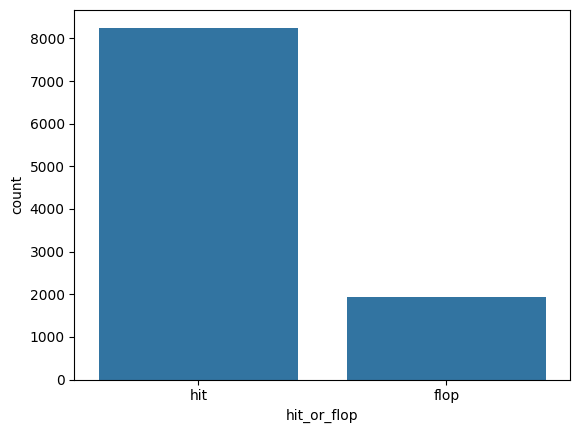

In [10]:
sns.countplot(x='hit_or_flop', data=movies_df)
movies_df.loc[:, "hit_or_flop"].value_counts()

**Selecting features for the decision tree**

In [11]:
movies_df["genre"] = movies_df["genre"].fillna("Unknown")

In [12]:
genre_dummies = movies_df["genre"].str.get_dummies(sep=",")

In [13]:
movies_df["crew"] = movies_df["crew"].fillna("Unknown")
movies_df["crew_list"] = movies_df["crew"].apply(lambda x: [i.strip() for i in str(x).split(",")])
movies_df["director"] = movies_df["crew_list"].apply(lambda x: x[0] if len(x) > 0 else "Unknown")
movies_df["actor_count"] = movies_df["crew_list"].apply(len)

In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
movies_df["orig_lang_enc"] = le.fit_transform(movies_df["orig_lang"])
movies_df["country_enc"] = le.fit_transform(movies_df["country"])
movies_df["director_enc"] = le.fit_transform(movies_df["director"])

In [15]:
numeric_features = ["score", "budget_x", "actor_count"]
categorical_features = ["orig_lang_enc", "country_enc", "director_enc"]

X = pd.concat([movies_df[numeric_features + categorical_features], genre_dummies], axis=1)
y = movies_df["hit_or_flop"]
X.shape, X.isna().sum().sum(), y.value_counts()

((10178, 45),
 np.int64(0),
 hit_or_flop
 hit     8253
 flop    1925
 Name: count, dtype: int64)

**Transform the data**

Will be using the pipeline because it fits and transforms the categorical features of the data.

Building decesion tree model

In [16]:
# Train/test: 80/20 (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print('Shapes:')
print('  Train:', X_train.shape, y_train.shape)
print('  Test: ', X_test.shape, y_test.shape)

Shapes:
  Train: (8142, 45) (8142,)
  Test:  (2036, 45) (2036,)


Accuracy: 0.8241650294695482
              precision    recall  f1-score   support

        flop       0.56      0.31      0.40       385
         hit       0.85      0.94      0.90      1651

    accuracy                           0.82      2036
   macro avg       0.71      0.63      0.65      2036
weighted avg       0.80      0.82      0.80      2036



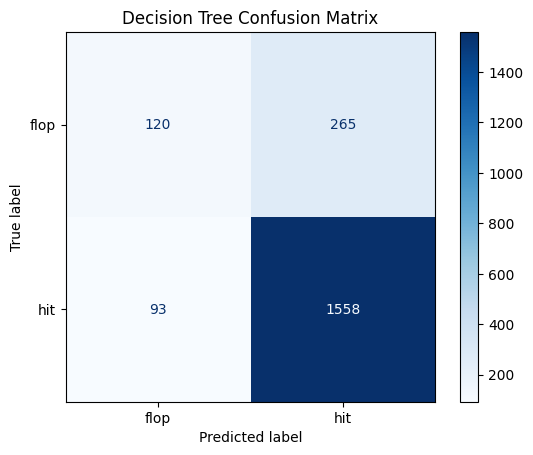

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

dt = DecisionTreeClassifier(
    max_depth=10,
    min_samples_leaf=20,
    random_state=42
)

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test, cmap="Blues")
plt.title("Decision Tree Confusion Matrix")
plt.show()

Train score 0.8477032670105625
Test score 0.8241650294695482


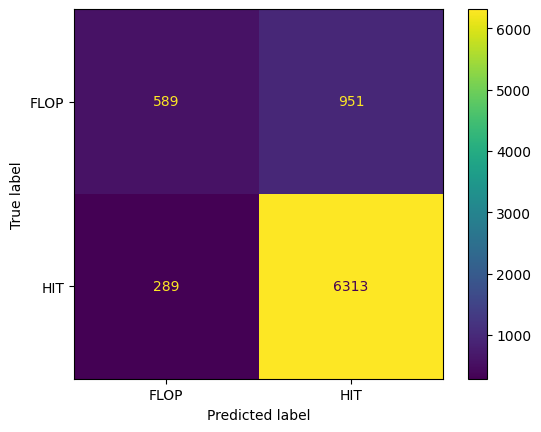

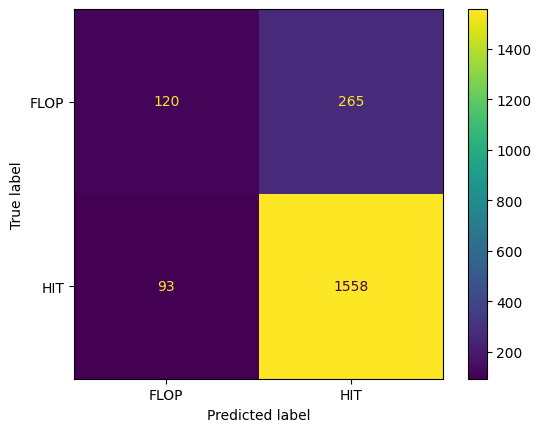

In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns

y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')

cfsm_1=ConfusionMatrixDisplay(confusion_matrix(y_train,y_train_pred), display_labels=["FLOP", "HIT"])
cfsm_2=ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_pred), display_labels=["FLOP", "HIT"])
cfsm_1.plot()
cfsm_2.plot()

Fold 1 Accuracy: 0.7829
Fold 2 Accuracy: 0.7692
Fold 3 Accuracy: 0.7834
Fold 4 Accuracy: 0.7646
Fold 5 Accuracy: 0.7877

Mean Accuracy: 0.7776
Standard Deviation: 0.0090

Confusion Matrix:
[[ 836 1089]
 [1175 7078]]


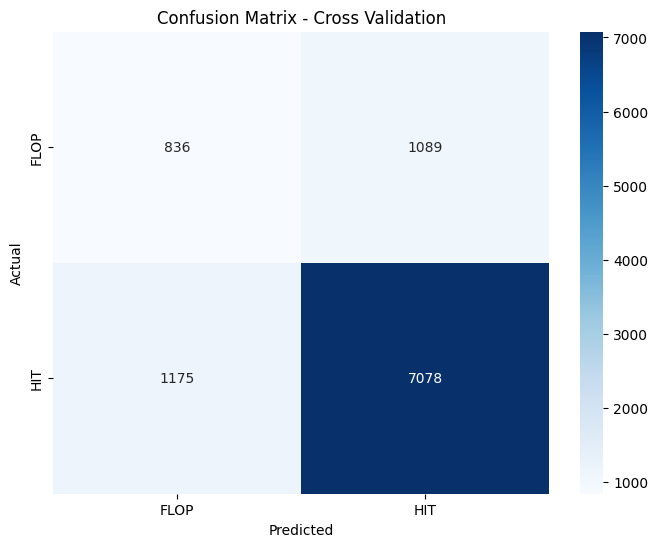

In [23]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

kfolds = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)

# Re-create the pipeline for cross-validation to ensure preprocessing is applied
cv_model = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Get accuracy scores for each fold
scores = cross_val_score(cv_model, X, y, cv=kfolds, scoring='accuracy')

# Print each fold's accuracy
for fold_num, score in enumerate(scores, 1):
    print(f"Fold {fold_num} Accuracy: {score:.4f}")

print(f"\nMean Accuracy: {scores.mean():.4f}")
print(f"Standard Deviation: {scores.std():.4f}")

# Get predictions for confusion matrix
predicted = cross_val_predict(cv_model, X, y, cv=kfolds)

# Create and display confusion matrix
cm = confusion_matrix(y, predicted)
print("\nConfusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["FLOP", "HIT"], yticklabels=["FLOP", "HIT"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Cross Validation')
plt.show()

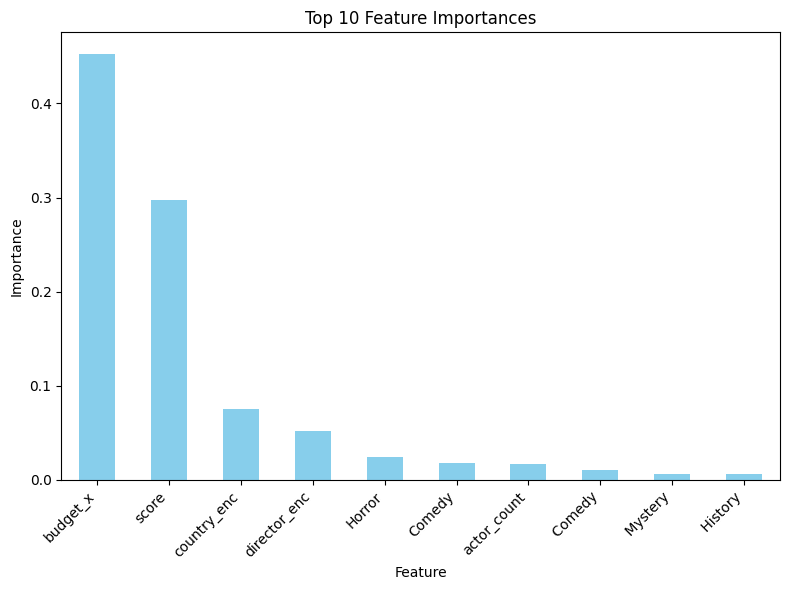

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

importances = pd.Series(dt.feature_importances_, index=X.columns)
top10 = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,6))
top10.plot(kind='bar', color='skyblue')
plt.title("Top 10 Feature Importances")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

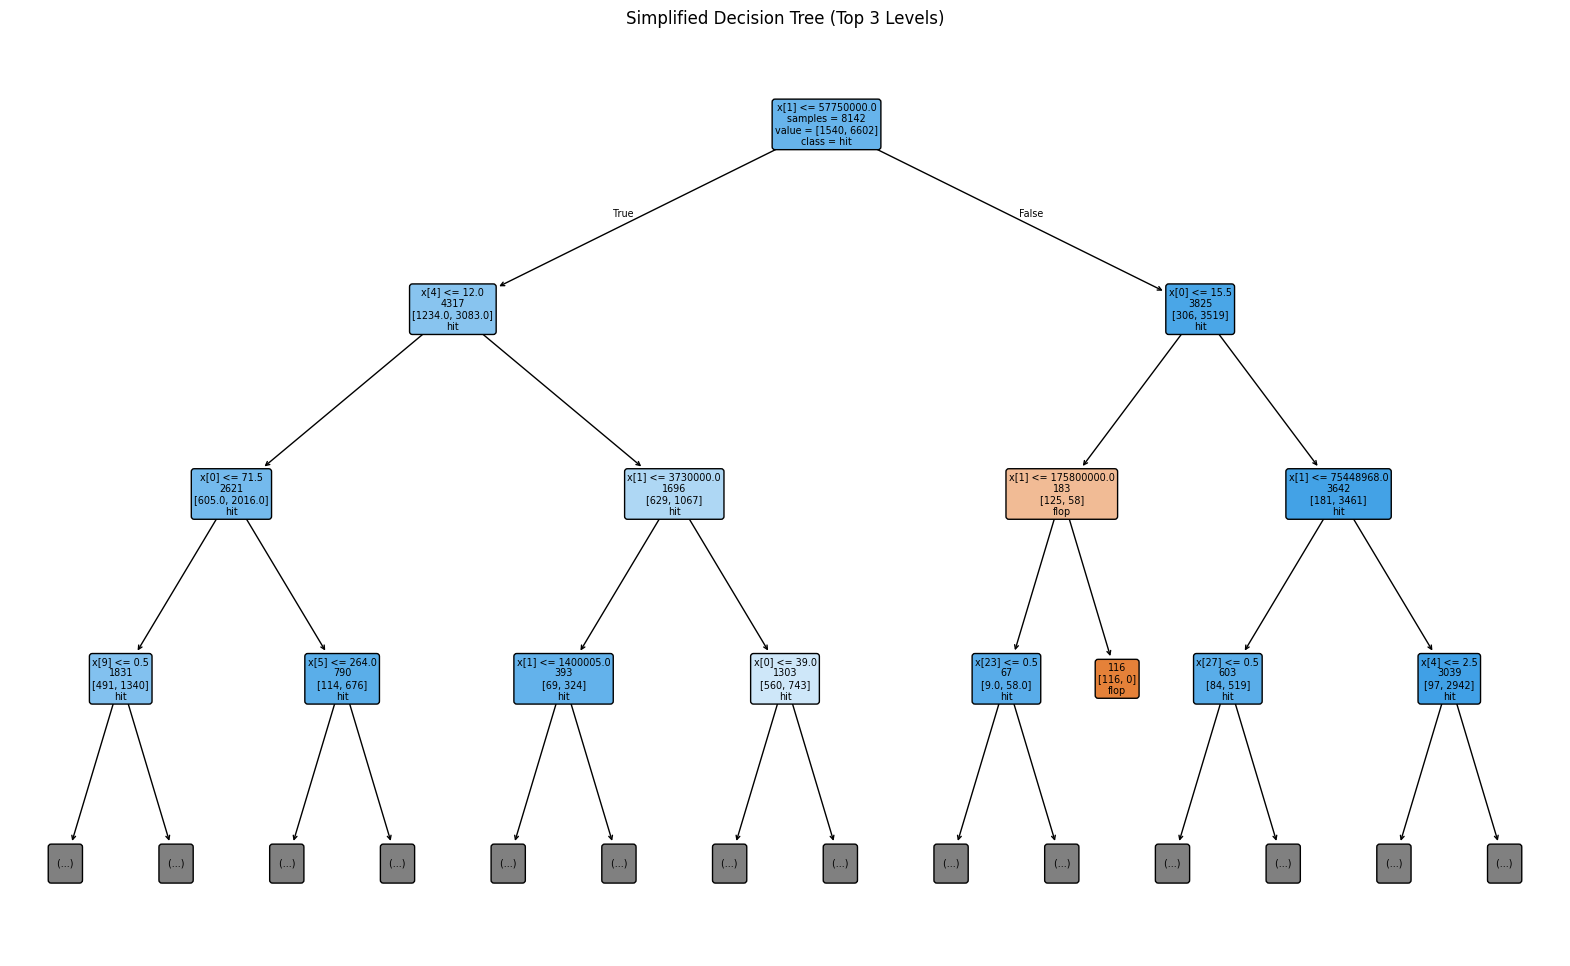

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 12))
plot_tree(
    dt,
    max_depth=3,
    filled=True,
    rounded=True,
    class_names=['flop', 'hit'],
    impurity=False,
    label='root',
)
plt.title("Simplified Decision Tree (Top 3 Levels)")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def evaluate_dt(X, y, desc):
    """Train/test split + decision tree + print accuracy"""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,
        random_state=42
    )

    dt = DecisionTreeClassifier(
        max_depth=10,
        min_samples_leaf=20,
        random_state=42
    )
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{desc}  accuracy: {acc:.4f}")
    return acc

In [ ]:
# Experiment 1: full feature set (current version)
X_full = X.copy()
acc_full = evaluate_dt(X_full, y, "Full feature set")

Full feature set  accuracy: 0.8242


In [ ]:
# Experiment 2: drop actor_count only
cols_drop = ["actor_count"]
X_reduced = X_full.drop(columns=cols_drop)

acc_reduced = evaluate_dt(X_reduced, y, "Without actor_count")

Without actor_count  accuracy: 0.8197


In [ ]:
# Experiment 3: model accuracy after removing director_enc
cols_drop = ["director_enc"]
X_no_director = X_full.drop(columns=cols_drop)

acc_no_director = evaluate_dt(X_no_director, y, "Without director_enc")

Without director_enc  accuracy: 0.8310


In [ ]:
# Experiment 4: model accuracy after removing all genre_dummies
genre_cols = genre_dummies.columns
X_no_genre = X_full.drop(columns=genre_cols)

acc_no_genre = evaluate_dt(X_no_genre, y, "Without genre features")

Without genre features  accuracy: 0.8374


In [ ]:
# Experiment 5: model accuracy after removing orig_lang_enc
cols_drop = ["orig_lang_enc"]
X_no_lang = X_full.drop(columns=cols_drop)
acc_no_lang = evaluate_dt(X_no_lang, y, "Without orig_lang_enc")

Without orig_lang_enc  accuracy: 0.8242


In [ ]:
# Experiment 6: model accuracy after removing country_enc
cols_drop = ["country_enc"]
X_no_country = X_full.drop(columns=cols_drop)
acc_no_country = evaluate_dt(X_no_country, y, "Without country_enc")

Without country_enc  accuracy: 0.8296


In [ ]:
# Experiment 7: numeric-only features
numeric_only_cols = ["score", "budget_x"]
X_numeric_only = X_full[numeric_only_cols]

acc_numeric = evaluate_dt(X_numeric_only, y, "Numeric features only (score, budget)")

Numeric features only (score, budget)  accuracy: 0.8232


In [ ]:
#Experiment 8: Using only genre information
X_genre_only = genre_dummies
acc_genre = evaluate_dt(X_genre_only, y, "Genre-only features")

Genre-only features  accuracy: 0.8109


In [ ]:
# Experiment 9: adding a binned budget feature (low/medium/high)
movies_temp = movies_df.copy()

# Create budget bins (3 quantiles: low / medium / high)
movies_temp["budget_bin"] = pd.qcut(
    movies_temp["budget_x"],
    q=3,
    labels=["low", "medium", "high"]
)

budget_dummies = pd.get_dummies(movies_temp["budget_bin"], prefix="budget_bin")

X_binned = pd.concat(
    [
        movies_temp[["score", "actor_count", "orig_lang_enc", "country_enc", "director_enc"]],
        genre_dummies,
        budget_dummies
    ],
    axis=1
)

acc_binned = evaluate_dt(X_binned, y, "With binned budget feature")

With binned budget feature  accuracy: 0.8222


In [ ]:
import pandas as pd

results = pd.DataFrame([
    ["Full feature set",                acc_full],
    ["Without actor_count",             acc_reduced],
    ["Without director_enc",            acc_no_director],
    ["Without genre features",          acc_no_genre],
    ["Without orig_lang_enc",           acc_no_lang],
    ["Without country_enc",             acc_no_country],
    ["Numeric only (score, budget_x)",  acc_numeric],
    ["Genre-only features",             acc_genre],
    ["With binned budget feature",      acc_binned],
], columns=["Experiment", "Accuracy"])

results.sort_values("Accuracy", ascending=False, inplace=True)
results.reset_index(drop=True, inplace=True)
results

,Experiment,Accuracy
0,Without genre features,0.837426
1,Without director_enc,0.831041
2,Without country_enc,0.829568
3,Full feature set,0.824165
4,Without orig_lang_enc,0.824165
5,"Numeric only (score, budget_x)",0.823183
6,With binned budget feature,0.822200
7,Without actor_count,0.819745
8,Genre-only features,0.810904


In [ ]:
# Final feature set: drop genre features and director_enc
cols_to_drop = list(genre_dummies.columns) + ["director_enc"]
X_final = X_full.drop(columns=cols_to_drop)

X_final.shape

(10178, 5)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Train-test split on final feature set
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final, y, test_size=0.2, stratify=y, random_state=42
)

# Final decision tree model
dt_final = DecisionTreeClassifier(
    max_depth=10,
    min_samples_leaf=20,
    random_state=42
)

dt_final.fit(X_train_final, y_train_final)
y_pred_final = dt_final.predict(X_test_final)

print("Final model accuracy:", accuracy_score(y_test_final, y_pred_final))

Final model accuracy: 0.8305500982318271


add new data to the model to see what it predicted

In [ ]:
new_movie_raw = pd.DataFrame([{
    'names': "Five Nights at Freddy's 2",
    'date_x': '12/05/2025',
    'score': 60,
    'genre': 'Horror, Mystery',
    'overview': 'A year after the events of the first film, the terror returns and secrets of Freddy’s are revealed.',
    'crew': 'Emma Tammi, Scott Cawthon, Jason Blum',
    'orig_title': 'New Hero Movie',
    'status': 'Upcoming',
    'orig_lang': 'English',
    'budget_x': 51000000,
    'country': 'US'
}])

In [ ]:
new_movie_raw["genre"] = new_movie_raw["genre"].fillna("Unknown")

new_movie_raw["crew"] = new_movie_raw["crew"].fillna("Unknown")
new_movie_raw["crew_list"] = new_movie_raw["crew"].apply(lambda x: [i.strip() for i in str(x).split(",")])
new_movie_raw["director"] = new_movie_raw["crew_list"].apply(lambda x: x[0] if len(x) > 0 else "Unknown")
new_movie_raw["actor_count"] = new_movie_raw["crew_list"].apply(len)

lang_map = (
    movies_df[["orig_lang", "orig_lang_enc"]]
    .drop_duplicates()
    .set_index("orig_lang")["orig_lang_enc"]
    .to_dict()
)

# country_enc
country_map = (
    movies_df[["country", "country_enc"]]
    .drop_duplicates()
    .set_index("country")["country_enc"]
    .to_dict()
)

# director_enc
director_map = (
    movies_df[["director", "director_enc"]]
    .drop_duplicates()
    .set_index("director")["director_enc"]
    .to_dict()
)

new_movie_raw["orig_lang_enc"] = new_movie_raw["orig_lang"].map(lang_map)
new_movie_raw["country_enc"]   = new_movie_raw["country"].map(country_map)
new_movie_raw["director_enc"]  = new_movie_raw["director"].map(director_map)

new_movie_raw[["orig_lang_enc", "country_enc", "director_enc"]] = (
    new_movie_raw[["orig_lang_enc", "country_enc", "director_enc"]]
    .fillna(-1)
    .astype(int)
)

In [ ]:
numeric_features = ["score", "budget_x", "actor_count"]
categorical_features = ["orig_lang_enc", "country_enc"]

X_new = new_movie_raw[numeric_features + categorical_features]

prediction = dt_final.predict(X_new)
print("Prediction:", prediction[0])

Prediction: hit
